# 2D Convolutional Neural Networks

In this lab, we will train a traditional VGG16 model, where we will train the last couple of layers to adapt it to our problem. We will also study how to use Pytorch directly, without Keras, and [torchvision](https://pytorch.org/vision/main/), the image subpackage from torch.

The problem is to predict one of 6 categories of pictures, whether they are. 'buildings', 'forest', 'glacier', 'mountain', 'sea' or 'street'. This problem comes from an Intel Image Classification challenge and is available [here](https://www.kaggle.com/puneet6060/intel-image-classification/version/2).


In [ ]:
# Base
import numpy as np
import PIL
import os
from datetime import datetime
import pandas as pd


# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from IPython.display import Image
%matplotlib inline
graphviz.set_jupyter_format('jpg')

# Torch
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split

# Torchcam
from torchcam.methods import SmoothGradCAMpp, GradCAM
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.utils import overlay_mask


Now, we can load the data.

In [ ]:
!gdown 'https://drive.google.com/uc?id=1HEB7JHl6uSANiENvaHBxhzmkkZ9YlhEC'

Downloading...
From (original): https://drive.google.com/uc?id=1HEB7JHl6uSANiENvaHBxhzmkkZ9YlhEC
From (redirected): https://drive.google.com/uc?id=1HEB7JHl6uSANiENvaHBxhzmkkZ9YlhEC&confirm=t&uuid=c644d618-7297-43f1-b897-c88be9e7ffcf
To: /content/IntelClassification.zip
100% 255M/255M [00:01<00:00, 206MB/s]


In [ ]:
!unzip IntelClassification.zip

Streaming output truncated to the last 5000 lines.
  inflating: IntelClassification/seg_train/mountain/7539.jpg  
  inflating: IntelClassification/seg_train/mountain/7551.jpg  
  inflating: IntelClassification/seg_train/mountain/7560.jpg  
  inflating: IntelClassification/seg_train/mountain/7565.jpg  
  inflating: IntelClassification/seg_train/mountain/7578.jpg  
  inflating: IntelClassification/seg_train/mountain/7581.jpg  
  inflating: IntelClassification/seg_train/mountain/7586.jpg  
  inflating: IntelClassification/seg_train/mountain/7647.jpg  
  inflating: IntelClassification/seg_train/mountain/7652.jpg  
  inflating: IntelClassification/seg_train/mountain/7654.jpg  
  inflating: IntelClassification/seg_train/mountain/7662.jpg  
  inflating: IntelClassification/seg_train/mountain/767.jpg  
  inflating: IntelClassification/seg_train/mountain/7672.jpg  
  inflating: IntelClassification/seg_train/mountain/7679.jpg  
  inflating: IntelClassification/seg_train/mountain/7681.jpg  
  inf

In [ ]:
# Let's remove a few samples for speed.
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
for model_class in classes:
  l = os.listdir(os.path.join('IntelClassification/seg_train', model_class))
  for n in l[::2]:
      os.unlink(os.path.join('IntelClassification/seg_train', model_class, n))

Let's see a couple of examples.

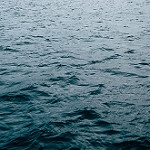

In [ ]:
Image(filename='IntelClassification/seg_train/sea/17997.jpg')

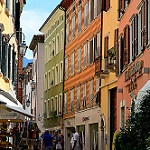

In [ ]:
Image(filename='IntelClassification/seg_test/street/20066.jpg')

Finally, let's verify torch is running on GPU. The following code gets that and also allocates the device (the GPU) to a variable.

In [ ]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The default device is set to {device}")

Is CUDA supported by this system? True
CUDA version: 12.4
ID of current CUDA device: 0
Name of current CUDA device: Tesla T4
The default device is set to cuda


All good! Now we can run our models in GPU.

## VGG16

The VGG 16 model is a classic model in Deep Learning. It is a 16 layer model, following the structure that we discussed in the lectures.

This model was trained over the ImageNet data, thus looking to classify among 1000 different types of objects, over a very large database of images. We can leverage these already-trained weights, and  adapt just the last few layers for our purposes.

We start by loading the VGG16 model. Torch comes pre-packaged with a series of models, loaded into the [Models library in torchvision](https://pytorch.org/vision/main/models.html). We start by first loading the model on-the-fly using the library. We can check the options of the model in the options of the function [VGG16](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html#torchvision.models.vgg16).

This will download the model and save it to our unoriginally named variable model. It is a pretty beefy download, at around 500MB. Luckly we have fast internet in Colab :). It uses the default weights which were pretrained by Torch.

We then move the model to the GPU.

In [ ]:
# Load the model from pytorch using default weights.
model = torchvision.models.vgg16(weights='DEFAULT')
print(f"This model is trained for {model.classifier[6].out_features} classes")

# Move to the GPU
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 117MB/s]


This model is trained for 1000 classes


We now show the basic structure of the model.

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Due to the structure of torch, visualizing models is hard. We can however use some packages to print models. They are a bit experimental, so careful on complex models. This one though is simple.

In [ ]:
!pip install torchview

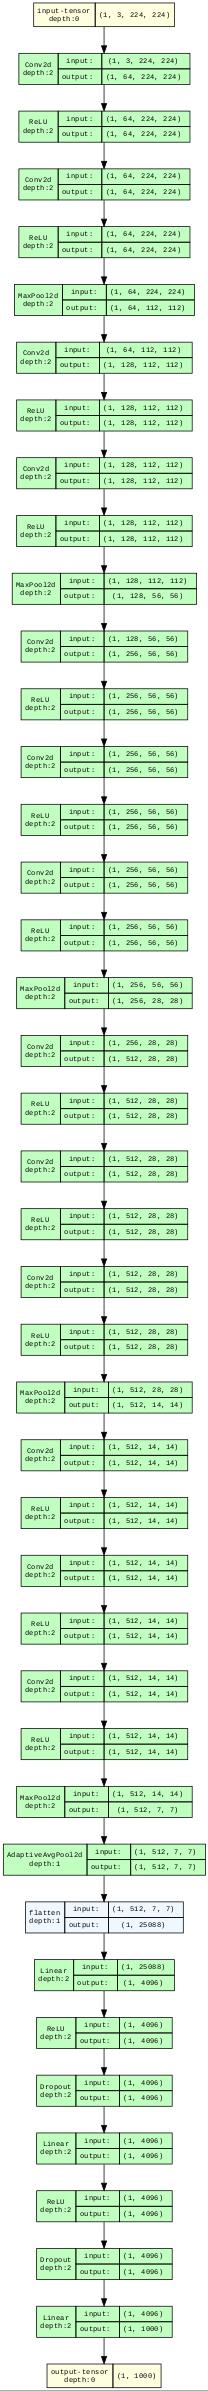

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1,3,224,224), device=device)
model_graph.visual_graph

At this point, every single parameter is trainable. We don't need this, as we want to use the parameters that come with the model. We will change the model to first keep all convolutional layers constant, and we will also change the "top" of the model, that is, the layers that lead to classification. These are the ones that are above the "Flatten" layer.

The following code does that.

In [ ]:
# List the indexes of the top layers
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

In [ ]:
# Replace the top layer. Reduce size to 128 and output layer to 6.
model.classifier[0] = torch.nn.Linear(in_features=25088, out_features=128, bias=True)
model.classifier[3] = torch.nn.Linear(in_features=128, out_features=128, bias=True)
model.classifier[6] = torch.nn.Linear(in_features=128, out_features=6, bias=True)

# Add a softmax layer at the end to change the logits to probabilities.
model.classifier = torch.nn.Sequential(
        *model.classifier,
        torch.nn.Softmax(dim=1),
)

# Set the last layer of the feature part of the model as trainable
trainable_layers = [28, 29, 30]
for layer in trainable_layers:
  for param in model.features[layer].parameters():
    param.require_grad = True

# Move to the GPU
model = model.to(device)
print(next(model.parameters()).is_cuda) # Should say True

True


In [ ]:
# Check the new model if it worked.
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Ready! We can now load the data. We have our set of pictures ready for this example. For this problem we will use a generator. A generator takes images from a directory, and feeds them to the model as needed. **This is necessary to work with big data**. We cannot expect the datasets we work here to fit in memory, so we take the images as needed.

We will now generate a function to load the training data. This will take a directory and apply augmentations to the data to improve training efficiency. This will use pytorch's [torchvision](https://pytorch.org/vision/stable/index.html) package that comes with functions tailored to image data.

In [ ]:
# Get the transforms for VGG16
transforms_vgg16 = torchvision.models.VGG16_Weights.DEFAULT.transforms

def load_image_data_trainval(data_dir='IntelClassification/seg_train',
                            batch_size=32,
                            validation_split=0.33,
                            random_seed=42):
    """
    Load an image dataset and splits it into training and validation sets.

    Parameters:
    - data_dir (str): Path to the data directory.
    - batch_size (int): Number of images to be loaded in each batch.
    - validation_split (float): The fraction of the dataset to be used as validation set.
    - random_seed (int): A seed to ensure reproducibility for the random split.

    Returns:
    - train_loader (DataLoader): DataLoader for the training set.
    - val_loader (DataLoader): DataLoader for the validation set.
    """

    # Define a transformation pipeline
    transform = transforms.Compose([
        transforms_vgg16(),
        v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
        v2.RandomHorizontalFlip(p=0.5)
        ])

    # Create the dataset using ImageFolder
    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    # Determine the split sizes
    total_size = len(full_dataset)
    val_size = int(validation_split * total_size)
    train_size = total_size - val_size

    # Ensure reproducibility of the split
    torch.manual_seed(random_seed)

    # Split the dataset
    train_dataset, val_dataset = random_split(full_dataset,
                                              [train_size, val_size])

    # Create the DataLoaders to feed data to the model
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

    return train_loader, val_loader

For the test set, we will create a generator that applies no transformations to the data except resizing and centering.

In [ ]:
def load_image_test_dataset(data_dir='IntelClassification/seg_test',
                            batch_size=32):
    """
    Load the IntelClassification image dataset.

    Parameters:
    - data_dir (str): Path to the data directory (the directory should contain 'train' and 'test' subdirectories).
    - batch_size (int): Number of images to be loaded in each batch.

    Returns:
    - DataLoader: PyTorch DataLoader for the dataset.
    """

    # Test data has no transformations beyond the basics.
    transforms_list = [
        transforms_vgg16()
    ]

    # Initialize the transformation function
    transform = transforms.Compose(transforms_list)

    # Create the dataset using ImageFolder
    full_data_dir = os.path.join(data_dir)
    dataset = datasets.ImageFolder(root=full_data_dir, transform=transform)

    # Create the DataLoader to feed data to the model
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False)

    return dataloader

We must now create our data loaders.

In [ ]:
train_loader, val_loader = load_image_data_trainval(batch_size=64)
test_loader = load_image_test_dataset(batch_size=64)

print(f"The train set has {len(train_loader.dataset)} images.")
print(f"The validation set has {len(val_loader.dataset)} images.")
print(f"The test set has {len(test_loader.dataset)} images.")

The train set has 4701 images.
The validation set has 2315 images.
The test set has 3000 images.


Let's visualize a few examples.

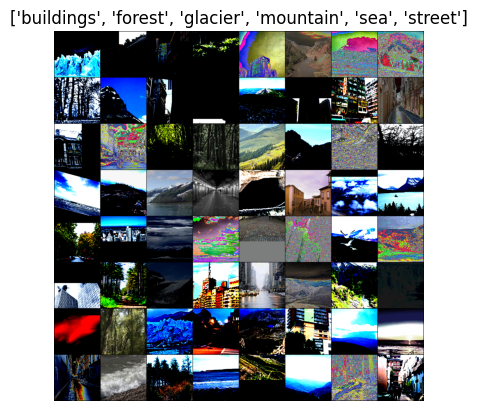

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[x for x in classes])

# Get a batch of training data
inputs, classes = next(iter(train_loader))
show_databatch(inputs, test_loader.dataset.classes)

Now we can create the train loop. In Pytorch, we must be explicit in each of the operations of the backpropagation algorithm. This allows us to control the training loop explicitely, but it does lead to a somewhat extensive codebase.

The good news is that this is boilerplate and can be copy-pasted with ease for future projects. First, let's define the loss and optimizer.

In [ ]:
# Defining the loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Defining the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

To monitor the training loop, we'll use the [livelossplot](https://p.migdal.pl/livelossplot/) package. It is a simple interface to visualize training as it happens.

In [ ]:
!pip install livelossplot

Now we'll define the training loop. The following code does ```EPOCHS``` rounds of training, showing the ongoing loss every 10 batches. Once per epoch, liveloss is updated.

In [ ]:
# Set validation loss to a large amount first.
best_vloss = 1000000

In [ ]:
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

liveloss = PlotLosses()
EPOCHS = 1
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

for epoch in range(EPOCHS):
   # Run the epoch
  logs = {}

  # Run a train epoch, and then a validation epoch.
  for phase in ['train', 'validation']:
      if phase == 'train':
          model.train()
      else:
          model.eval()

      running_loss = 0.0
      running_corrects = 0

      for i, data in enumerate(dataloaders[phase]):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(inputs).to(device)
          loss = loss_fn(outputs, labels)

          if phase == 'train':
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          _, preds = torch.max(outputs, 1)
          running_loss += loss.detach() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

          if i % 10 == 9:
            batch_loss = running_loss / (10 * (i+1))
            print(f'{phase} batch {i+1} loss: {batch_loss:.3f}')
            tb_x = epoch * len(dataloaders[phase]) + i + 1

          # Delete the used VRAM
          torch.cuda.empty_cache()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

      prefix = ''
      if phase == 'validation':
          prefix = 'val_'

          # Track best performance, and save the model's state
          if epoch_loss < best_vloss:
              best_vloss = epoch_loss
              model_path = 'model_{}_{}.ph'.format(timestamp, epoch)
              print(f'New best model found. Saving it as {model_path}')
              torch.save(model.state_dict(), model_path)

      logs[prefix + 'log loss'] = epoch_loss.item()
      logs[prefix + 'accuracy'] = epoch_acc.item()

  liveloss.update(logs)
  liveloss.send()

train batch 10 loss: 11.467
train batch 20 loss: 11.454
train batch 30 loss: 11.443
train batch 40 loss: 11.429
train batch 50 loss: 11.403
train batch 60 loss: 11.348
train batch 70 loss: 11.274
validation batch 10 loss: 10.141
validation batch 20 loss: 10.111
validation batch 30 loss: 10.150


NameError: name 'best_vloss' is not defined

In [ ]:
# Load the best
model.load_state_dict(torch.load('/content/model_20250319_171244_0.ph'))

As you can see, the model still has much more to learn! Keep training until you get convergence.

Now, let's apply it to the test set and get a confusion matrix.

In [ ]:
# Wrapper to save memory by not recomputing gradients.
with torch.no_grad():
    # Set the model in evaluation mode.
    model.eval()

    # Calculate running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    test_labels = np.array([])
    test_probs = np.array([])
    test_predictions = np.array([])

    # Apply to the test set
    for i, data in enumerate(test_loader):
        inputs, labels = data
        test_labels = np.append(test_labels, labels.cpu().numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        test_probs = np.append(test_probs, outputs.cpu().numpy())
        outputs = outputs.to(device)
        loss = loss_fn(outputs, labels)

        _, preds = torch.max(outputs, 1)
        test_predictions = np.append(test_predictions, preds.cpu().numpy())
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

test_loss = running_loss / len(test_loader.dataset)
test_acc = running_corrects.float() / len(test_loader.dataset)

print(f'The test set accuracy is {test_acc*100:.2f}%')
print(f'The test set loss is {test_loss:.3f}')

The test set accuracy is 52.73%
The test set loss is 1.533


In [ ]:
test_probs

array([0.92402995, 0.00696691, 0.01131397, ..., 0.01056257, 0.02336455,
       0.51645464], shape=(18000,))

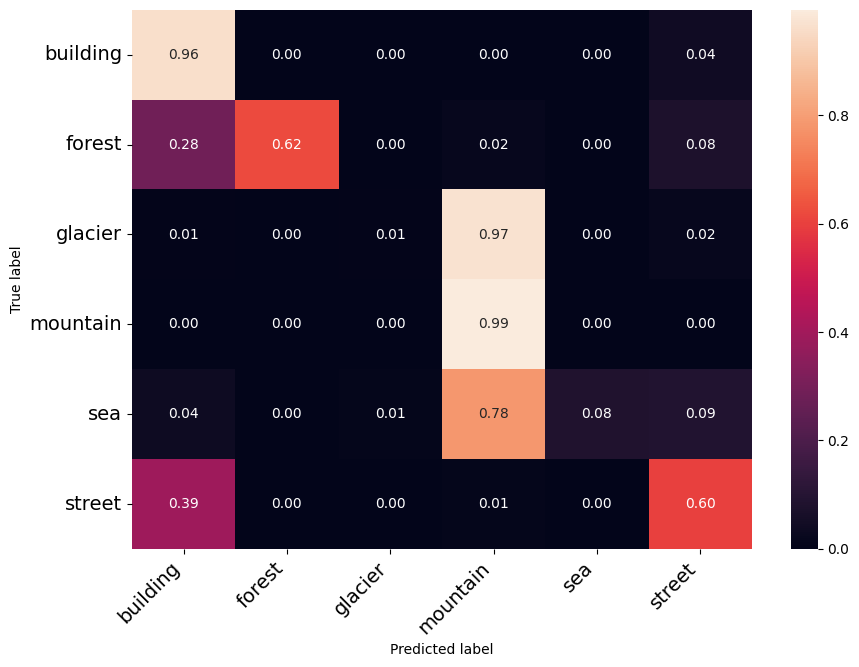

In [ ]:
# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = test_labels,
                    y_pred = test_predictions)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net,
        index=['building', 'forest', 'glacier', 'mountain', 'sea', 'street'],
        columns=['building', 'forest', 'glacier', 'mountain', 'sea', 'street'],
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

Excellent results!! We can now take the latest weights we created and recreate the weights without any further training, or keep training to reach a better accuracy. A few more rounds and the accuracy can get up to 95% or so.

## Visualizing learning

As a final example. We will visualize the learning, to detect exactly what is happening.

We will use [SmoothCAM](https://arxiv.org/pdf/2006.14255.pdf), a method that allows visualizing how one image activates the neural network by tracing the gradient activations. There are several Pytorch implementations and non of them is dominant. [torch-cam](https://github.com/frgfm/torch-cam) comes with both activation-level and gradient-level models, so it serves our purposes. Let's install the paper.

The package will extract the gradients automatically when we evaluate a model. Note that gradients must be allow to float, so the wrapper ```with torch.no_grad()``` should not be used in this case, but the model can be placed in evaluation mode.

We also must point the model to a layer. In general, you want to point it to the last convolutional layer of the feature extractor. We do that in the definition of the object resulting from the function ```SmoothGradCAMpp```.

In [ ]:

# Set model to evaluation mode and apply the model.
model.eval()
cam_extractor = SmoothGradCAMpp(model, target_layer=model.features[28])

Now we extract an image and apply the VGG16 transforms.

In [ ]:
# Get your input
img_path = 'IntelClassification/seg_test/sea/20072.jpg'
img = read_image(img_path)

# Preprocess for the model
transforms = transforms_vgg16 = torchvision.models.VGG16_Weights.DEFAULT.transforms()
input_tensor = transforms(img)

Now we are ready to get the output. We apply the model using the ```cam_extractor``` object as a wrapper, which will record our gradients and calculate the algorithm. We save the outcome on the variable ```activation_map```.

In [ ]:
with cam_extractor:
  # Preprocess your data and feed it to the model
  out = model(input_tensor.unsqueeze(0).to(device))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

AssertionError: Inputs need to be forwarded in the model for the conv features to be hooked

In [ ]:
out

We can see the model predicts with a 100% probability that the model is of class 'forest', which is correct. Let's see what it is doing to make this happen.

In [ ]:
# Visualize the raw CAM
activation_map_raw = activation_map[0].squeeze(0).cpu().numpy()
plt.imshow(activation_map_raw)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img),
                      to_pil_image((255*activation_map_raw).astype(np.uint8)),
                      alpha=0.7)

# Display it
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()

Now we can clearly see what is happening.

This is the importance of the modelling procedures: We need to understand how much diversity we are including in our images: If we don't we might end up learning other things!

Now change the image and study what is the model doing.